<a href="https://colab.research.google.com/github/liang-faan/python-ml/blob/main/USML_1_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the following packages
!pip3 install pycaret[full] ydata_profiling swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import swifter
import pandas as pd
import numpy as np
from pathlib import Path

## RFM Segmentation

Load the dataset online_retail.csv and use clustering techniques to segment the customers based on RFM (recency, frequency, monetary value).

> Recency — How recently did the customer purchase?

> Frequency — How often do they purchase?

> Monetary Value — How much do they spend?

Customer segmentation will aid the precision marketing efforts of the company.

The dataset is a transnational dataset containing all the retail transactions that occured between 01/12/2010 and 09/12/2011 for a UK-based pure online retail.
The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [ ]:
# Load the dataset
data_path = Path('/content/drive/MyDrive/pcml_data/6USML')

filename = 'online_retail.csv'

df = pd.read_csv(
    data_path / filename,
    encoding='ISO-8859-1',
    header=0
)

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
391157,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-09-12 12:50:00,0.85,12680.0,France
391158,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-09-12 12:50:00,2.10,12680.0,France
391159,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-09-12 12:50:00,4.15,12680.0,France
391160,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-09-12 12:50:00,4.15,12680.0,France


#### Dataset Inspection

Descriptive statistics

In [ ]:
from ydata_profiling import ProfileReport

# Create a profile report
df.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Next, we are going to engineer retail features that can help us segment customers according to relevant business objectives - (1) market share (revenue), (2) profit margin.

Retail transaction features that directly influence the above objectives:

> Recency (R)
>> Number of days since last purchase (measures customer repeat frequency, a measure of product demand, customer loyalty)
>
> Frequency (F)
>> Number of transactions
>
> Monetary (M)
>> Total revenue contributed

#### Step 1: Compute Recency

We can use the %%timeit magic function to check the speed of code execution

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391162 entries, 0 to 391161
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    391162 non-null  int64  
 1   StockCode    391162 non-null  object 
 2   Description  391162 non-null  object 
 3   Quantity     391162 non-null  int64  
 4   InvoiceDate  391162 non-null  object 
 5   UnitPrice    391162 non-null  float64
 6   CustomerID   391162 non-null  float64
 7   Country      391162 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 23.9+ MB


In [ ]:
import datetime

In [ ]:
# Convert invoice date to datetime object
%%timeit
df['InvoiceDate'] = df.InvoiceDate.apply(pd.to_datetime)

833 ms ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Compare the above with swifter
%%timeit
df['InvoiceDate'] = df.InvoiceDate.swifter.apply(pd.to_datetime)

137 ms ± 6.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Find the last date of purchase for each customer

# Since the dataset might not be recent, thus we benchmark
# it against the last date of purchase of the dataset

# Linear models will suffer from a truncation effect if
# there is a long period of break between the last record
# of the dataset and now. Although standardization can reduce
# it, there is no reason to risk it.

df['recency'] = max(df.InvoiceDate) - df.InvoiceDate

In [ ]:
# sort values in ascending order
df.sort_values('recency', ascending=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,recency
281465,570876,23503,PLAYING CARDS KEEP CALM & CARRY ON,4,2011-12-10 17:19:00,1.25,16085.0,United Kingdom,0 days 00:00:00
281447,570876,46000S,POLYESTER FILLER PAD 40x40cm,1,2011-12-10 17:19:00,1.45,16085.0,United Kingdom,0 days 00:00:00
281448,570876,46000M,POLYESTER FILLER PAD 45x45cm,1,2011-12-10 17:19:00,1.55,16085.0,United Kingdom,0 days 00:00:00
281449,570876,23394,POSTE FRANCE CUSHION COVER,1,2011-12-10 17:19:00,3.75,16085.0,United Kingdom,0 days 00:00:00
281450,570876,23396,LE JARDIN BOTANIQUE CUSHION COVER,1,2011-12-10 17:19:00,3.75,16085.0,United Kingdom,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00


In [ ]:
# Extract the latest transaction on a customer basis
rfm_r = df.groupby('CustomerID')['recency'].min()
rfm_r

CustomerID
12346.0   326 days 07:18:00
12347.0    40 days 04:54:00
12348.0    76 days 04:06:00
12349.0    19 days 07:28:00
12350.0   311 days 01:18:00
                 ...       
18280.0   160 days 07:27:00
18281.0     4 days 06:26:00
18282.0   216 days 03:44:00
18283.0    10 days 04:20:00
18287.0     0 days 06:56:00
Name: recency, Length: 4335, dtype: timedelta64[ns]

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_r = rfm_r.reset_index().set_index('CustomerID')

In [ ]:
# For modeling purposes, we need to convert a datetime
# object (in this case, a timedelta object) to an integer/float
# For this use-case, number of days is the most appropriate
# rfm_r['recency']=rfm_r.recency.days
rfm_r.recency=rfm_r.recency.dt.days

#### Step 2: Compute Frequency

In [ ]:
# This metric is simply a count of the number of
# unique items per transaction that a customer makes

# Each unique item in the given dataset is
# indicated under the respective invoice number.
# E.g. Invoice number 536365 includes the first
# 5 stockcodes.

# Why unique items per transaction and not
# number of items purchased?
# Due to the nature of the items purchased, if we
# use number of items purchased, we will end up
# giving more weights to customers that purchase
# small items at high quantity.

# Why unique items per transactions and not number of
# unique invoices? Some customers may purchase a large
# number of items per invoice while others split up
# their purchases. The difference is likely attributed
# to customer idiosyncracies or the presence of discounts
# or unique circumstances. Since there are many confounding
# possibilities, we balance these considerations and use
# unique items per transaction.

rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_f = rfm_f.reset_index().set_index('CustomerID')
rfm_f.rename({'InvoiceNo':'frequency'})


,InvoiceNo
CustomerID,
12346.0,1
12347.0,182
12348.0,27
12349.0,72
12350.0,16
...,...
18280.0,10
18281.0,7
18282.0,12


#### Compute Monetary

In [ ]:
# Monetary metric is simply total revenue generated
# by each customer

# First, we compute the total revenue generated per
# line item
df['monetary'] = df.Quantity * df.UnitPrice

In [ ]:
# Next, we group them by customers
rfm_m = df.groupby('CustomerID')['monetary'].sum()

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_m = rfm_m.reset_index().set_index('CustomerID')

#### Merging

Here, we pool all the dataframes together so that we have the RFM metrics per customer.

In [ ]:
# We use the concat function so that we can
# merge all 3 dataframes in 1 pass.

# Remember to specify axis=1 so that the datasets
# are joined by columns, else they will be stacked (append)

# Lastly, since we require all rows to have values, we use
# inner join which will drop any customer id that have missing
# values for either R, F, or M.

rfm = pd.concat([rfm_r, rfm_f, rfm_m], axis=1, join='inner')

In [ ]:
# Save the model
rfm.to_csv('/content/drive/MyDrive/2023-SMU-MachineLearning/6USML/rfm.csv');

In [ ]:
# If we take a break from the project, we
# can load the rfm file here and continue
rfm = pd.read_csv('/content/drive/MyDrive/2023-SMU-MachineLearning/6USML/rfm.csv')

### Inspecting the dataset

In [ ]:
# Check distribution of RFM
rfm.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Modeling

Let's use clustering techniques to segment the customers.

In [ ]:
from pycaret.clustering import *

ModuleNotFoundError: ignored

In [ ]:
rfm_study = setup(
    data=rfm,
    normalize=True, # This is import to have for unsupervised ML
    )

,Description,Value
0,Session id,7272
1,Original data shape,"(4335, 3)"
2,Transformed data shape,"(4335, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [ ]:
# What are the available models?
models()

NameError: ignored

In [ ]:
# Fit a model to the data
kmeans = create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5535,2570.9579,0.7493,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Ensure that the notebook can show plots inline
%matplotlib inline

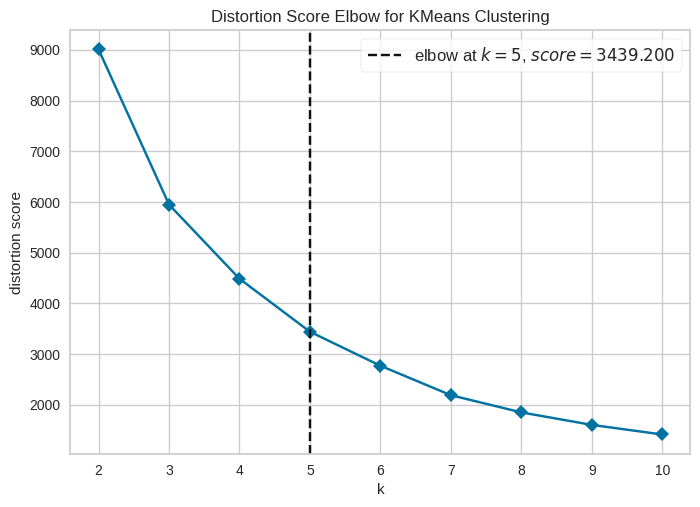

In [ ]:
# Inspect the Elbow Plot to shortlist the optimal number of clusters
plot_model(kmeans, plot = 'elbow')

In [ ]:
# Fit a kmeans model to the data with 3 to 7 clusters
# ## Check the performance scores to identify the optimal number of clusters

results = pd.DataFrame()


for n in range(3, 8):
  number_model = pull(create_model('kmeans', num_clusters=n))
  number_model.index=[n]
  results = results.append(number_model)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5535,2570.9579,0.7493,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5505,2743.3563,0.6053,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5760,3010.8680,0.7117,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5726,3201.1041,0.6645,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5657,3566.7448,0.6272,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
results

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
3,0.5535,2570.9579,0.7493,0,0,0
4,0.5505,2743.3563,0.6053,0,0,0
5,0.5760,3010.8680,0.7117,0,0,0
6,0.5726,3201.1041,0.6645,0,0,0
7,0.5657,3566.7448,0.6272,0,0,0


In [ ]:
# Final model - cluster size of ?
kmeans = create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5760,3010.8680,0.7117,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Score each observation
rfm_cluster = assign_model(kmeans)

In [ ]:
rfm_cluster

,recency,InvoiceNo,monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.601562,Cluster 4
12347.0,40,182,4310.000000,Cluster 0
12348.0,76,27,1437.239990,Cluster 0
12349.0,19,72,1457.550049,Cluster 0
12350.0,311,16,294.399994,Cluster 1
...,...,...,...,...
18280.0,160,10,180.600006,Cluster 1
18281.0,4,7,80.820000,Cluster 0
18282.0,216,12,178.050003,Cluster 1


# More analysis

In [ ]:
# Distribution plot
plot_model(kmeans, plot='distribution')

In [ ]:
# TSNE plot
plot_model(kmeans, plot='tsne')

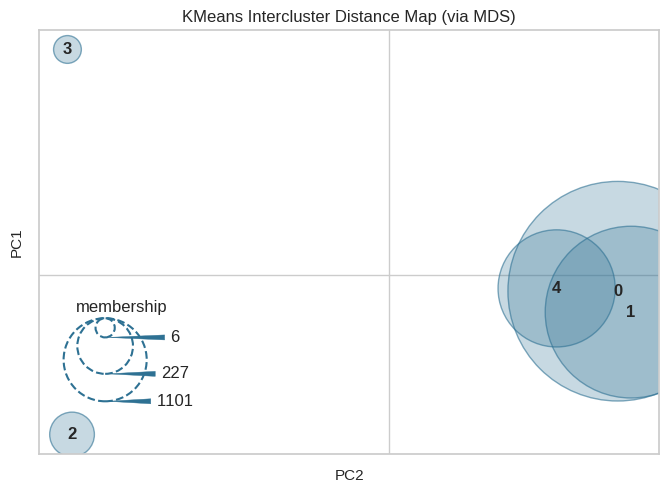

In [ ]:
# Distance plot
plot_model(kmeans, plot='distance')

#### Inspecting the results

Here, we use visualizations to derive insights from the clustering results.

In [ ]:
import seaborn as sns

In [ ]:
# Clusters vs Recency
sns.boxplot(data=rfm_cluster, x='Cluster', y='recency')

TypeError: ignored

Are the clusters well separated in terms of recency of purchase?

>Cluster __ - Last purchase most recent
>
>Cluster __ - Last purchase most distant


<AxesSubplot:xlabel='Cluster', ylabel='frequency'>

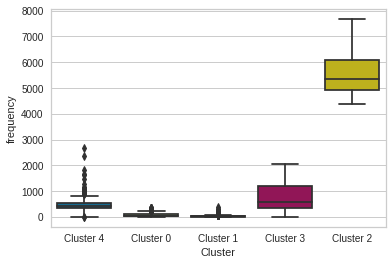

In [ ]:
# Clusters vs Frequency
sns.boxplot()

Are the clusters well separated in terms of frequency of purchase?

>Cluster __ - Highest frequency
>
>Cluster __ - Lowest frequency

<AxesSubplot:xlabel='Cluster', ylabel='monetary'>

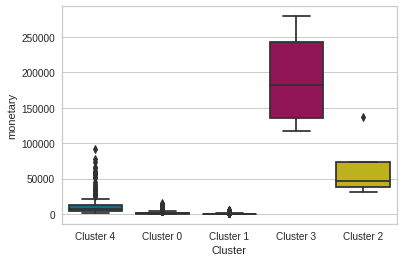

In [ ]:
# Clusters vs Monetary Value
sns.boxplot()

Are the clusters well separated in terms of monetary value?

>Cluster __ - Contributes the highest revenue
>
>Cluster __ - Lowest revenue

How would you tag the persona for the various clusters? What strategies will you use to target them?

Class Exercise: Please perform the same process in PyCaret but use
1. hclust - hierarchical clustering
2. ap - affinity propagation

In [ ]:
# What are the available models?
models()

INFO:logs:gpu_param set to False


,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
hclust = create_model('hclust')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2956,1340.7874,1.0299,0,0,0


INFO:logs:create_model_container: 40
INFO:logs:master_model_container: 40
INFO:logs:display_container: 13
INFO:logs:AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
db = create_model('dbscan')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.415,221.8033,1.0567,0,0,0


INFO:logs:create_model_container: 41
INFO:logs:master_model_container: 41
INFO:logs:display_container: 14
INFO:logs:DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
ap = create_model('ap')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2399,1822.0538,0.9042,0,0,0


INFO:logs:create_model_container: 42
INFO:logs:master_model_container: 42
INFO:logs:display_container: 15
INFO:logs:AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None,
                    random_state='warn', verbose=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
plot_model(hclust, plot='distribution')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(ap, plot='distribution')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................
